In [239]:
import datasets
from typing import List, Optional, Dict
import torch
import numpy as np
import pandas as pd
from datasets import Dataset, load_metric
from transformers import pipeline, TextClassificationPipeline, AutoTokenizer, DistilBertTokenizerFast, Trainer, IntervalStrategy, AutoModelForSequenceClassification, TrainingArguments
from transformers.pipelines.base import GenericTensor
import torch
import pandas as pd
import seaborn as sns

from torch import tensor 
from transformers.pipelines import TextClassificationPipeline
from captum.attr import LayerIntegratedGradients, TokenReferenceBase
from captum.attr import visualization as viz

import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import MultiLabelClassificationExplainer

In [240]:
label_replacements = {
    'av': {
        'c2i': {'N': 0, 'L': 1, 'A': 2, 'P': 3},
        'i2c': {0: 'N', 1: 'L', 2: 'A', 3: 'P'}
    },
    'ac': {
        'c2i': {'L': 0, 'H': 1},
        'i2c': {0: 'L', 1: 'H'}
    },
    'pr': {
        'c2i': {'L': 0, 'H': 1, 'N': 2},
        'i2c': {0: 'L', 1: 'H', 2: 'N'}
    },
    'ui': {
        'c2i': {'R': 0, 'N': 1},
        'i2c': {0: 'R', 1: 'N'}
    },
    's': {
        'c2i': {'C': 0, 'U': 1},
        'i2c': {0: 'C', 1: 'U'}
    },
    'c': {
        'c2i': {'H': 0, 'N': 1, 'L': 2},
        'i2c': {0: 'H', 1: 'N', 2: 'L'}
    },
    'i': {
        'c2i': {'H': 0, 'N': 1, 'L': 2},
        'i2c': {0: 'H', 1: 'N', 2: 'L'}
    },
    'a': {
        'c2i': {'H': 0, 'N': 1, 'L': 2},
        'i2c': {0: 'H', 1: 'N', 2: 'L'}
    }
}

In [241]:
class MyPipeline(TextClassificationPipeline):
    def preprocess(self, inputs, **tokenizer_kwargs) -> Dict[str, GenericTensor]:
        return_tensors = self.framework
        return self.tokenizer(inputs, return_tensors=return_tensors, padding="max_length", truncation=True, max_length=512, **tokenizer_kwargs)

In [314]:
dataset_path = "dataset/distilbert-base-uncased/train.json"
base_model = "distilbert-base-uncased"
checkpoint_path = "checkpoints/distilbert"
target_var = "a"
cve_id = "CVE-2020-4905"
replacements = label_replacements[target_var]['i2c']

In [315]:
df = pd.read_json(dataset_path, orient='records', lines=True)
df = df.drop(columns=['input_ids', 'attention_mask', ])#'token_type_ids'
number_of_labels = len(df[target_var].unique())

In [316]:
model_path = f"{checkpoint_path}/distil_{target_var}/checkpoint-final"
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=number_of_labels)

In [317]:
tokenizer = AutoTokenizer.from_pretrained(base_model)
pipe = MyPipeline(model=model, tokenizer=tokenizer, function_to_apply="softmax", device=-1)

In [318]:
#Code von Mykhailo Kushnir: https://levelup.gitconnected.com/huggingface-transformers-interpretability-with-captum-28e4ff4df234
class ExplainableTransformerPipeline():
    """Wrapper for Captum framework usage with Huggingface Pipeline"""
    
    def __init__(self, name:str, pipeline: TextClassificationPipeline, device: str):
        self.__name = name
        self.__pipeline = pipeline
        self.__device = device
    
    def forward_func(self, inputs: tensor, position = 0):
        """
            Wrapper around prediction method of pipeline
        """
        pred = self.__pipeline.model(inputs, attention_mask=torch.ones_like(inputs))
        return pred[position]
        
    def visualize(self, inputs: list, attributes: list):
        """
            Visualization method.
            Takes list of inputs and correspondent attributs for them to visualize in a barplot
        """
        attr_sum = attributes.sum(-1) 
        
        attr = attr_sum / torch.norm(attr_sum)
        
        a = pd.Series(attr.numpy()[0], index = self.__pipeline.tokenizer.convert_ids_to_tokens(inputs.detach().numpy()[0]))

        a.sort_values(inplace=True, ascending=False)
        #plt.show(a.plot.barh(figsize=(10,20)))



        print("-"*10 + "Top" + "-"*10)
        print(a[:10])
        print("-"*10 + "Flop" + "-"*10)
        print(a[-10:])

        return a

    def explain(self, text: str):
        """
            Main entry method. Passes text through series of transformations and through the model. 
            Calls visualization method.
        """
        prediction = self.__pipeline(text)
        inputs = self.generate_inputs(text)
        baseline = self.generate_baseline(sequence_len = inputs.shape[1])
        
        lig = LayerIntegratedGradients(self.forward_func, getattr(self.__pipeline.model, 'distilbert').embeddings)
        
        attributes, delta = lig.attribute(inputs=inputs, baselines=baseline, target = self.__pipeline.model.config.label2id[prediction[0]['label']], return_convergence_delta = True)
        
        #print(inputs)
        #print(attributes)

        prediction = prediction[0]['label']
        prediction = prediction.replace('LABEL_', '')
        prediction = replacements[int(prediction)]
        print("Prediction: " + prediction)
        return self.visualize(inputs, attributes)
        
    def generate_inputs(self, text: str) -> tensor:
        """
            Convenience method for generation of input ids as list of torch tensors
        """
        return torch.tensor(self.__pipeline.tokenizer.encode(text, add_special_tokens=False), device = self.__device).unsqueeze(0)
    
    def generate_baseline(self, sequence_len: int) -> tensor:
        """
            Convenience method for generation of baseline vector as list of torch tensors
        """        
        return torch.tensor([self.__pipeline.tokenizer.cls_token_id] + [self.__pipeline.tokenizer.pad_token_id] * (sequence_len - 2) + [self.__pipeline.tokenizer.sep_token_id], device = self.__device).unsqueeze(0)

In [319]:
device = 'cpu'
#sample = df.iloc[169] #Soll:N Ist:L
#sample = df.iloc[42] #Soll:N Ist:L
sample = df.loc[df['id'] == cve_id].iloc[0].squeeze()
sample

id                                           CVE-2020-4905
text     IBM Financial Transaction Manager for SWIFT Se...
av                                                       N
ac                                                       H
pr                                                       N
ui                                                       N
s                                                        U
c                                                        H
i                                                        N
a                                                        N
score                                                  5.9
Name: 58370, dtype: object

In [320]:
exp_model = ExplainableTransformerPipeline('distilbert', pipe, device)
a = exp_model.explain(sample['text'])

Prediction: N
----------Top----------
financial      0.521596
sensitive      0.388793
information    0.314030
sensitive      0.302682
information    0.229254
obtain         0.195596
transaction    0.147802
could          0.147462
manager        0.146200
ibm            0.134734
dtype: float64
----------Flop----------
could      0.023566
.          0.022819
3          0.007477
swift      0.002765
ss         0.002385
the       -0.000173
4         -0.012412
multi     -0.018224
##forms   -0.107981
.         -0.150665
dtype: float64


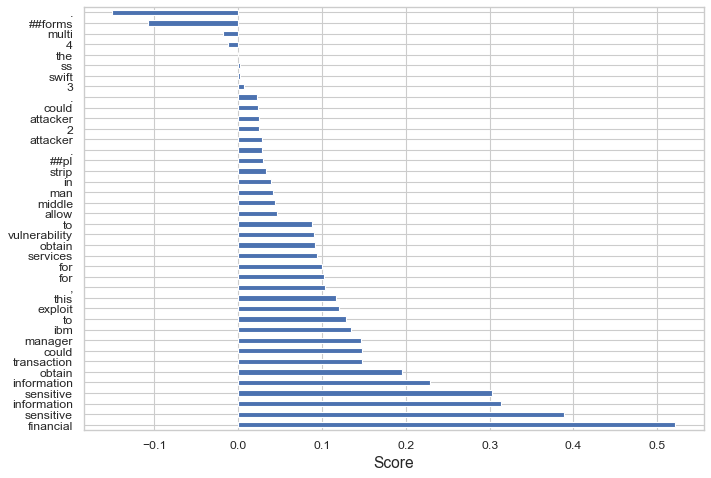

In [321]:
s = pd.concat([a[:20], a[-20:]])
fig, ax = plt.subplots(figsize=(10,7), dpi= 80)
s.plot.barh()
plt.xlabel('Score', fontsize=14)
fig.savefig(f'../assets/explainability/exp_{base_model}_{target_var}_{sample["id"]}.png', facecolor=fig.get_facecolor(), edgecolor='none')

In [322]:
class MyMultiLabelClassificationExplainer(MultiLabelClassificationExplainer):
    def visualize(self, html_filepath: str = None, true_class: str = None):
        """
        Visualizes word attributions. If in a notebook table will be displayed inline.

        Otherwise pass a valid path to `html_filepath` and the visualization will be saved
        as a html file.

        If the true class is known for the text that can be passed to `true_class`

        """
        tokens = [token.replace("Ġ", "") for token in self.decode(self.input_ids)]

        score_viz = [
            self.attributions[i].visualize_attributions(  # type: ignore
                self.pred_probs[i],
                "",  # including a predicted class name does not make sense for this explainer
                "n/a" if not true_class else true_class,  # no true class name for this explainer by default
                replacements[int(self.labels[i].replace("LABEL_", ""))],
                tokens,
            )
            for i in range(len(self.attributions))
        ]


        html = viz.visualize_text(score_viz)

        new_html_data = html._repr_html_().replace("Predicted Label", "Prediction Score")
        new_html_data = new_html_data.replace("True Label", "n/a")
        html.data = new_html_data

        if html_filepath:
            if not html_filepath.endswith(".html"):
                html_filepath = html_filepath + ".html"
            with open(html_filepath, "w") as html_file:
                html_file.write(html.data)
        return html

In [323]:
cls_explainer = MyMultiLabelClassificationExplainer(model, tokenizer)

In [324]:
sample_text = sample['text']
sample_label = sample[target_var]
print(f'Sample: Label={sample_label} Text={sample_text}')
word_attributions = cls_explainer(sample_text)
cls_explainer.visualize('label_0_example.html', true_class='N')
#word_attributions

Sample: Label=N Text=IBM Financial Transaction Manager for SWIFT Services for Multiplatforms 3.2.4 could allow an remote attacker to obtain sensitive information, caused by a man in the middle attack. By SSL striping, an attacker could exploit this vulnerability to obtain sensitive information.


In [297]:
type(word_attributions['LABEL_1'])

list

In [298]:
type(word_attributions['LABEL_1'][0])

tuple

In [256]:
df_0 = pd.DataFrame(word_attributions['LABEL_0'], columns=['token', 'score'])
df_1 = pd.DataFrame(word_attributions['LABEL_1'], columns=['token', 'score'])
#df_2 = pd.DataFrame(word_attributions['LABEL_2'], columns=['token', 'score'])
#df_3 = pd.DataFrame(word_attributions['LABEL_3'], columns=['token', 'score'])

In [257]:
df_0['label'] = 'R'
df_1['label'] = 'N'
#df_2['label'] = 'N'
#df_3['label'] = 'P'

In [258]:
df = pd.concat([df_0, df_1,])

In [259]:
df

,token,score,label
0,[CLS],0.000000,R
1,an,0.016065,R
2,issue,0.000827,R
3,was,-0.046779,R
4,discovered,-0.118667,R
...,...,...,...
85,a,-0.212606,N
86,crafted,-0.188748,N
87,link,-0.159467,N
88,.,-0.679486,N


Text(0, 0.5, 'Score')

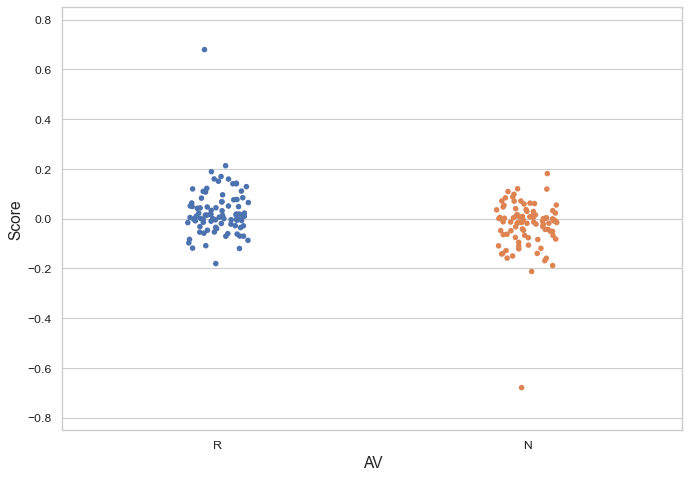

In [260]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,7), dpi= 80)
#ax = sns.boxplot(x="label", y="score", data=df, whis=np.inf)
ax = sns.stripplot(x="label", y="score", data=df, jitter=0.1)
ax.set_ylim(-0.85, 0.85)
plt.xlabel('AV', fontsize=14)
plt.ylabel('Score', fontsize=14)


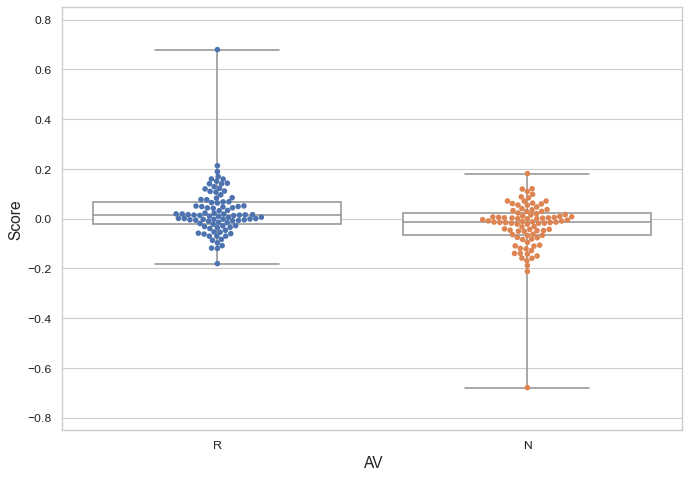

In [261]:
plt.figure(figsize=(10,7), dpi= 80)
ax = sns.boxplot(x="label", y="score", data=df, whis=np.inf, color="white")
ax = sns.swarmplot(data=df, x="label", y="score", size=5, )
ax.set_ylim(-0.85, 0.85)
#ax.text(0.8, 0.75, '"file"', style='italic')
plt.xlabel('AV', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.show()

In [325]:
df_0 = pd.DataFrame(word_attributions['LABEL_0'], columns=['token', 'H'])
df_1 = pd.DataFrame(word_attributions['LABEL_1'], columns=['token', 'score'])
df_2 = pd.DataFrame(word_attributions['LABEL_2'], columns=['token', 'score'])
#df_3 = pd.DataFrame(word_attributions['LABEL_3'], columns=['token', 'score'])
df_g = df_0
df_g['N'] = df_1['score']
df_g['L'] = df_2['score']
#df_g['P'] = df_3['score']
df_g = df_g[1:-1]
df_g

,token,H,N,L
1,ibm,-0.175502,0.097497,0.099705
2,financial,-0.533146,0.592495,-0.195739
3,transaction,-0.182260,0.137383,0.042745
4,manager,-0.029729,0.096241,-0.117269
5,for,0.023962,0.057351,-0.132521
6,swift,0.092252,0.007942,-0.152013
7,services,-0.011353,0.061134,-0.085812
8,for,-0.004983,0.048043,-0.073355
9,multi,0.039214,-0.004416,-0.051505
10,##pl,0.020829,0.022339,-0.068896


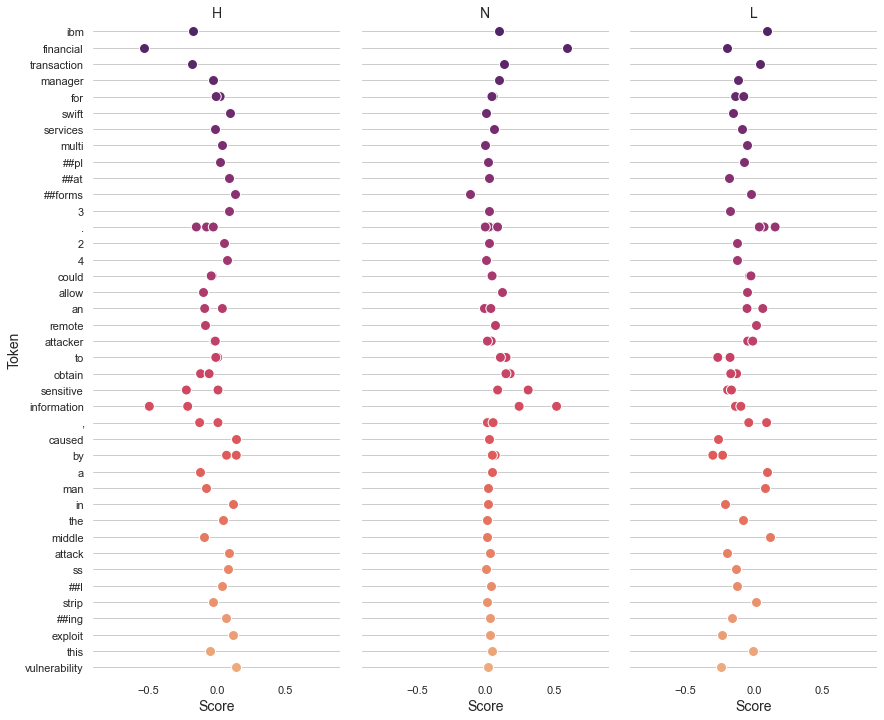

In [326]:
import matplotlib as mpl

mpl.rcParams["axes.labelsize"] = 14
# Make the PairGrid
g = sns.PairGrid(df_g, x_vars=df_g.columns[1:], y_vars=['token'], height=10, aspect=.4)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False, color='black', linewidth=1, edgecolor="w", palette="flare_r")
# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-0.9, 0.9), xlabel="Score", ylabel="Token", )

# Use semantically meaningful titles for the columns
titles = df_g.columns[1:]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set_title(title, fontsize=14)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

g.savefig(f'../assets/explainability/exp_{base_model}_{target_var}_{sample["id"]}_dots.png', facecolor=fig.get_facecolor(), edgecolor='none')